In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_fBiPotDDims.recursive_Markovian_PostMeanScore_fBiPot8Dims_T256_H05_tl_110data_StbleTgt_FULLDATA_LOWNOISE  import get_config

In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [3]:
def rmse_ignore_nans(y_true, y_pred):
    return np.nanmean((y_true-y_pred)**2)

def plot_ewma_losses(epochs, losses):
    start_idx = 00
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.99   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()


In [4]:
config = get_config()
deltaT = config.deltaT
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
print(config.loss_factor)

2


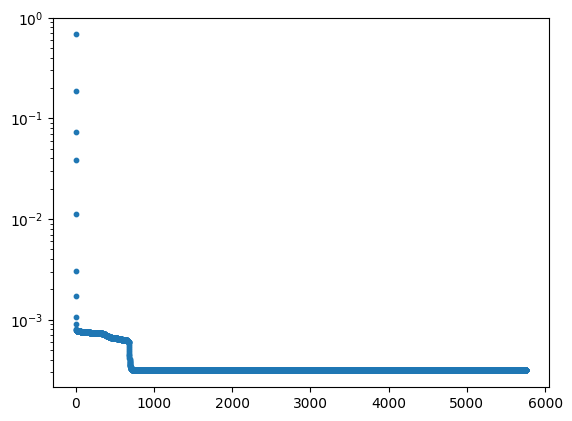

5762

In [5]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10)
plt.yscale("log")
plt.show()
plt.close()
Nepochs_losses[-1]

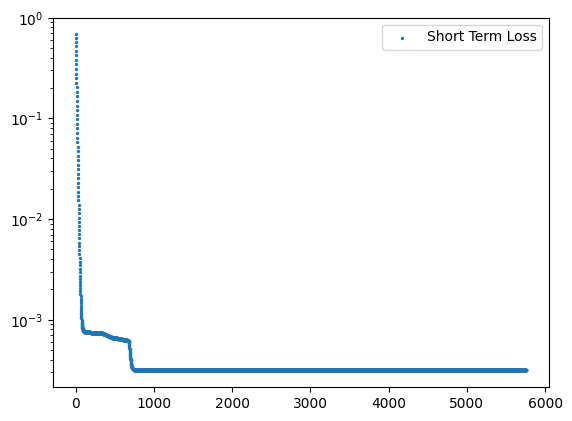

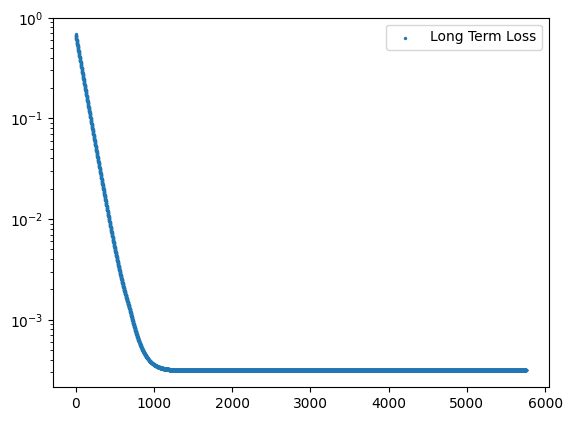

In [6]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

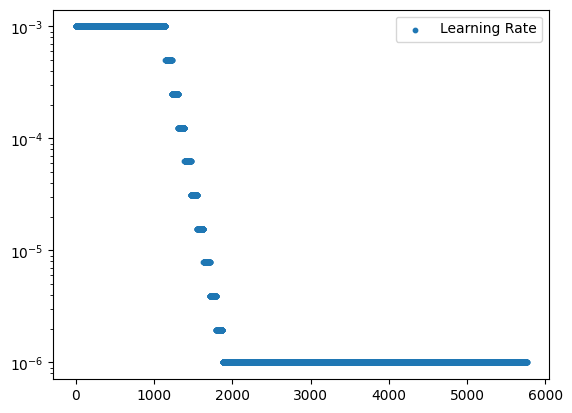

1e-06


In [7]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss_LR", 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0#935
end = -1#935+152
plt.scatter(Nepochs_losses[start:end],  LRs[start:end], s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(LRs[-1])

In [8]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)
Nepochs_losses = np.arange(losses.shape[0])
print(Nepochs_losses)

[   0    1    2 ... 5760 5761 5762]


In [9]:
import pandas as pd
root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/8DDimsLowNoise/"
mses=[]
for file in os.listdir(root_score_dir):
    if "MSE" in file:
        mses.append(pd.read_parquet(root_score_dir+file, engine="fastparquet"))
mses = pd.concat(mses).reset_index(drop=False).rename({"index":"epoch"}, axis=1).sort_values("epoch").reset_index(drop=True)
Nepochs_track = mses["epoch"].values.flatten()

In [10]:
mses_min = (mses.iloc[np.argmin(mses.dropna().mse)])
min_epoch = int(mses_min.epoch)
min_epoch

3877

In [14]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
common_epochs = np.intersect1d(common_epochs, np.arange(1000, 8000))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = np.unique([np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs])
track_idx = np.unique([np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs])
red_losses = losses[losses_idx]
print(track_idx.shape, common_epochs.shape)
#track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]
track_rmses = mses.iloc[track_idx,:].mse.values.flatten()
print(track_rmses.shape, common_epochs.shape)

(1485,) (1485,)
(1485,) (1485,)


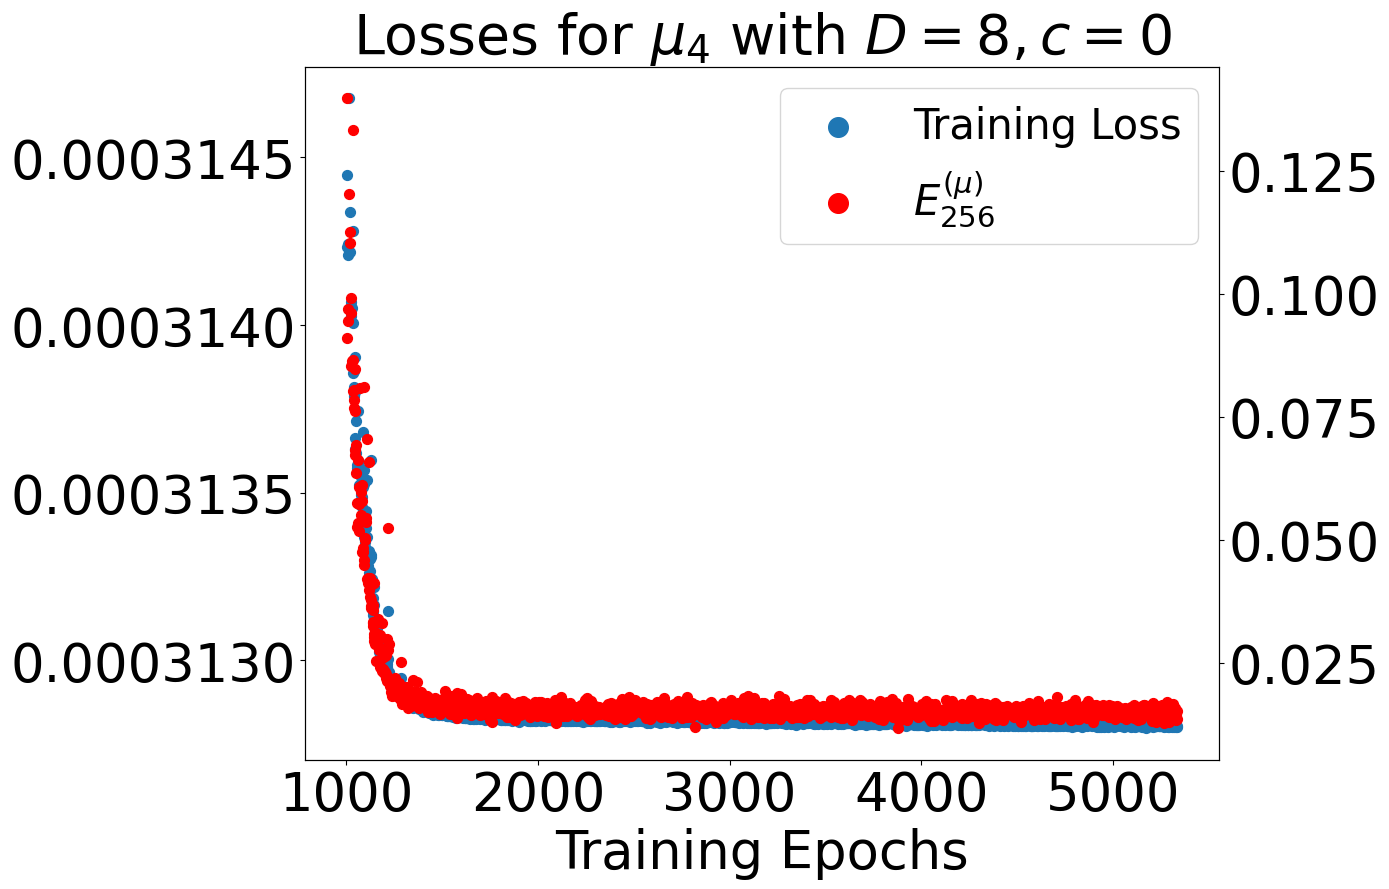

0.011748304780162732


In [15]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
max_idx = np.argwhere(common_epochs <=13000).flatten()[-1]
sc1 = ax.scatter(common_epochs[:max_idx+1], red_losses[:max_idx+1], s=50, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs[:max_idx+1], track_rmses[:max_idx+1], s=50, color="red",label="$E^{(\mu)}_{256}$")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(r"Losses for $\mu_{4}$ with $D=8, c=0$", fontsize=40)
ax.tick_params(axis="both",labelsize=38)
ax2.tick_params(axis="both",labelsize=38)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=30, markerscale=2)
if toSave:
    plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/8DDimsLowNoise/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDims_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()
print(mses.iloc[np.argmin(mses.mse), 1])

In [13]:
print(min_epoch)
Xs = np.load(root_score_dir+f"TSPM_MLP_ST_0010FTh_NSTgtNFMReg_fBiPot_{config.ndims}DDims_DriftEvalExp_{min_epoch}Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_locs.npy")
truemus = np.load(root_score_dir+f"TSPM_MLP_ST_0010FTh_NSTgtNFMReg_fBiPot_{config.ndims}DDims_DriftEvalExp_{min_epoch}Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_truemus.npy")
muhats = np.load(root_score_dir+f"TSPM_MLP_ST_0010FTh_NSTgtNFMReg_fBiPot_{config.ndims}DDims_DriftEvalExp_{min_epoch}Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_muhats.npy")

3877


FileNotFoundError: [Errno 2] No such file or directory: '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/8DDimsLowNoise/TSPM_MLP_ST_0010FTh_NSTgtNFMReg_fBiPot_8DDims_DriftEvalExp_3877Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_locs.npy'

In [ ]:
diff_times = np.linspace(config.train_eps, 1, config.max_diff_steps)
for d in range(muhats.shape[-1]):
    fig, ax = plt.subplots(figsize=(14,9))
    plt.scatter(Xs[:,d], truemus[:, d], color="red", label="True Drift")
    plt.scatter(Xs[:,d], muhats[:, d], label="Estimated Drift",color="blue")
    plt.title(rf"Score Estimator for $\mu_4$ with $D=8, c=0$", fontsize=50)
    plt.grid(True)
    plt.legend(fontsize=34, markerscale=2)
    ax.tick_params(labelsize=36)
    plt.ylabel("Drift Value", fontsize=45)
    plt.xlabel(rf"State $Y$", fontsize=45)
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"Dim {d+1} MSE is :", np.mean(np.power(truemus[:, d]-muhats[:, d], 2)))

In [ ]:
diff_times = np.linspace(config.train_eps, 1, config.max_diff_steps)
for d in range(muhats.shape[-1]):
    fig, ax = plt.subplots(figsize=(14,9))
    plt.scatter(Xs[:,d], truemus[:, d], color="red", label="True Drift")
    plt.scatter(Xs[:,d], muhats[:, d], label="Estimated Drift",color="blue")
    plt.title(rf"Score Estimator for $\mu_4$ with $D=8, c=0$", fontsize=50)
    plt.grid(True)
    plt.legend(fontsize=34, markerscale=2)
    ax.tick_params(labelsize=36)
    plt.ylabel("Drift Value", fontsize=45)
    plt.xlabel(rf"State $Y$", fontsize=45)
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"Dim {d+1} MSE is :", np.mean(np.power(truemus[:, d]-muhats[:, d], 2)))